<a href="https://colab.research.google.com/github/Jovenstriker/neural-networks/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math

In [ ]:
def sig(x):
  return 1/(1+np.exp(-x))
def sigDerv(x):
  return sig(x)*(1-sig(x))
def tanhDerv(x):
  return 1-math.tanh(x)**2


In [ ]:
class layer:
  def __init__(self):
    self.forgetInput = np.random.rand()
    self.forgetShortInput = np.random.rand()
    self.forgetBias = np.random.rand()
    self.inputInputSig = np.random.rand()
    self.inputShortInputSig = np.random.rand()
    self.inputSigBias = np.random.rand()
    self.inputInputTanh = np.random.rand()
    self.inputShortInputTanh = np.random.rand()
    self.inputTanhBias = np.random.rand()
    self.outputInput = np.random.rand()
    self.outputShortInput = np.random.rand()
    self.outputBias = np.random.rand()
  def forward(self,input,shortInput,longInput):
    self.input = input
    self.pastLongInput = longInput
    self.pastShortInput = shortInput
    self.longInput = longInput
    self.shortInput = shortInput #This would be the previous new output, not the predicted value
    self.forget = sig(self.shortInput*self.forgetShortInput + self.input*self.forgetInput + self.forgetBias)
    #Forget gate
    self.longInput *= self.forget
    #Input gate
    self.longInput+=sig(self.shortInput*self.inputShortInputSig + self.input*self.inputInputSig + self.inputSigBias)*math.tanh(self.shortInput*self.inputShortInputTanh + self.input*self.inputInputTanh + self.inputTanhBias)
    #Output gate
    self.result = sig(self.shortInput*self.outputShortInput + self.input*self.outputInput + self.outputBias)*math.tanh(self.longInput)
    #Result is the new short-term memory
    return [self.result,self.longInput]


In [ ]:
class NeuralNetwork:
  def __init__(self,layer):
    self.layer = layer

  def train(self,input):
    predictions = []
    for x in range(len(input)-1):
      longTerm = 0
      lastLongTerm = 0
      shortTerm = 0
      lastShortTerm = 0
      for y in range(x+1):
        lastLongTerm = longTerm
        lastShortTerm = shortTerm
        shortTerm,longTerm = self.layer.forward(input[y],shortTerm,longTerm)
      prediction = longTerm #= longTerm
      predictions.append(prediction)
      error = input[1+x]-prediction
      costGradient = 2*(prediction-input[1+x])
      #Output gate
      dervOutputGate = costGradient*math.tanh(self.layer.longInput)
      dervLongTerm = costGradient*self.layer.result*tanhDerv(self.layer.longInput)

      #Input gate,
      dervInputSig = dervLongTerm * math.tanh(self.layer.shortInput*self.layer.inputShortInputTanh + self.layer.input*self.layer.inputInputTanh + self.layer.inputTanhBias)
      dervInputTanh = dervLongTerm * sig(self.layer.shortInput*self.layer.inputShortInputSig + self.layer.input*self.layer.inputInputSig + self.layer.inputSigBias)

      #Forget gate
      dervForget = dervLongTerm*self.layer.pastLongInput
      dervPastLong = dervLongTerm*self.layer.forget #Respect to c(t-1)




      #Output gate weights
      dervOutputInput = costGradient*math.tanh(self.layer.longInput)* sigDerv(self.layer.shortInput*self.layer.outputShortInput + self.layer.input*self.layer.outputInput + self.layer.outputBias)*self.layer.input
      dervOutputShortInput = (dervOutputInput/self.layer.input) *self.layer.pastShortInput
      dervOutputBias=dervOutputInput/self.layer.input

      #Forget gate weights, o=sig(self.shortInput*self.outputShortInput + self.input*self.outputInput + self.outputBias)
      dervForgetBias = costGradient*sig(self.layer.shortInput*self.layer.outputShortInput + self.layer.input*self.layer.outputInput + self.layer.outputBias)*tanhDerv(self.layer.longInput)*self.layer.pastLongInput*sigDerv(self.layer.shortInput*self.layer.forgetShortInput + self.layer.input*self.layer.forgetInput + self.layer.forgetBias)
      dervForgetInput= dervForgetBias*self.layer.input
      dervForgetShortInput = dervForgetBias*self.layer.pastShortInput
      #Input gate weights
      #Sig
      dervInputBiasSig = costGradient*sig(self.layer.shortInput*self.layer.outputShortInput + self.layer.input*self.layer.outputInput + self.layer.outputBias)*tanhDerv(self.layer.longInput)*math.tanh(self.layer.shortInput*self.layer.inputShortInputTanh + self.layer.input*self.layer.inputInputTanh + self.layer.inputTanhBias) * sigDerv(self.layer.shortInput*self.layer.inputShortInputSig + self.layer.input*self.layer.inputInputSig + self.layer.inputSigBias)
      dervInputInputSig= dervInputBiasSig * self.layer.input
      dervInputShortInputSig = dervInputBiasSig * self.layer.pastShortInput

      #Tanh
      dervInputBiasTanh = costGradient*sig(self.layer.shortInput*self.layer.outputShortInput + self.layer.input*self.layer.outputInput + self.layer.outputBias)*tanhDerv(self.layer.longInput)*sig(self.layer.shortInput*self.layer.inputShortInputSig + self.layer.input*self.layer.inputInputSig + self.layer.inputSigBias)*tanhDerv((self.layer.shortInput*self.layer.inputShortInputTanh + self.layer.input*self.layer.inputInputTanh + self.layer.inputTanhBias))
      dervInputInputTanh = dervInputBiasTanh*self.layer.input
      dervInputShortInputTanh = dervInputBiasTanh * self.layer.pastShortInput

      self.layer.forgetInput -= dervForgetInput
      self.layer.forgetShortInput -= dervForgetShortInput
      self.layer.forgetBias -= dervForgetBias
      self.layer.inputInputSig -= dervInputInputSig
      self.layer.inputShortInputSig -= dervInputShortInputSig
      self.layer.inputSigBias -= dervInputBiasSig
      self.layer.inputInputTanh -= dervInputInputTanh
      self.layer.inputShortInputTanh -= dervInputShortInputTanh
      self.layer.inputTanhBias -=  dervInputBiasTanh
      self.layer.outputInput -= dervOutputInput
      self.layer.outputShortInput -= dervOutputShortInput
      self.layer.outputBias -= dervOutputBias
    return predictions


[0.181417392508651, 1.8931763833181487, 2.8935614802231386, 3.8935614802327256, 4.893561480232726, 5.893561480232726, 6.893561480232726, 7.893561480232726, 8.893561480232727, 9.893561480232727, 10.893561480232727, 11.893561480232727, 12.893561480232727, 13.893561480232727, 14.893561480232727, 15.893561480232727, 16.893561480232727, 17.893561480232727, 18.893561480232727, 19.893561480232727, 20.893561480232727, 21.893561480232727, 22.893561480232727, 23.893561480232727, 24.893561480232727, 25.893561480232727, 26.893561480232727, 27.893561480232727, 28.893561480232727, 29.893561480232727, 30.893561480232727, 31.893561480232727, 32.89356148023273, 33.89356148023273, 34.89356148023273, 35.89356148023273, 36.89356148023273, 37.89356148023273, 38.89356148023273, 39.89356148023273, 40.89356148023273, 41.89356148023273, 42.89356148023273, 43.89356148023273, 44.89356148023273, 45.89356148023273, 46.89356148023273, 47.89356148023273, 48.89356148023273, 49.89356148023273, 50.89356148023273, 51.89

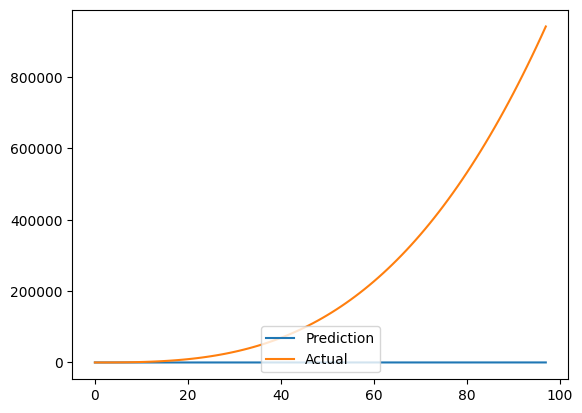

In [ ]:
netLayer= layer()
net = NeuralNetwork(netLayer)
inputData = []
def quadratic(x):
  return x*x
for i in range(1,100):
  inputData.append(i**3)
predictions = net.train(inputData)
from matplotlib import pyplot as plt
print(predictions)
plt.plot(predictions,label="Prediction")
plt.plot(inputData[:-1], label = "Actual")
leg = plt.legend(loc='lower center')
# plt.yscale('log')
plt.show()